Epoch 500, Loss: 0.000120
Epoch 1000, Loss: 0.000033


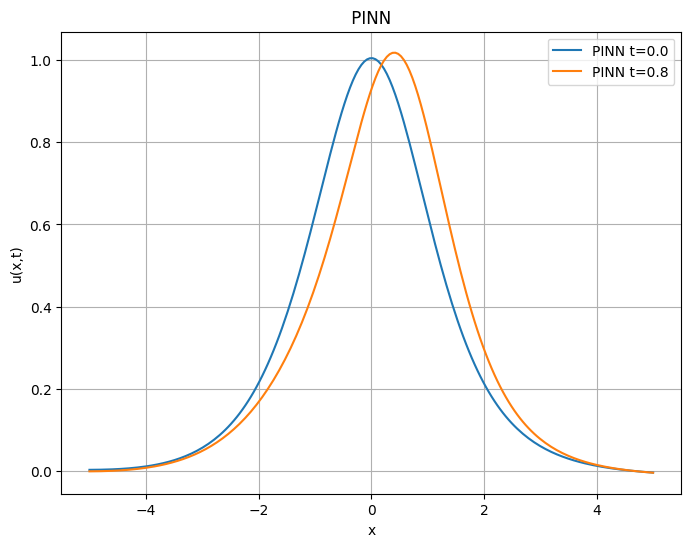

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

# Definir la red neuronal
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.hidden_layers.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, x, t):
        X = torch.cat((x, t), dim=1)
        for layer in self.hidden_layers[:-1]:
            X = torch.tanh(layer(X))
        output = self.hidden_layers[-1](X)
        return output

# Definir el residuo de la ecuación modificada
def pde_residual(x, t, model):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x, grad_outputs=torch.ones_like(u_xx), create_graph=True)[0]

    # Nueva ecuación diferencial: u_t + u u_x + 0.1 u_xxx = 0
    return u_t + u * u_x + 0.1 * u_xxx

# Definir la función de pérdida
def loss_function(model, x0, u0, x_colloc, t_colloc):
    pred_u0 = model(x0, torch.zeros_like(x0))
    mse_ic = torch.mean((pred_u0 - u0)**2)
    res = pde_residual(x_colloc, t_colloc, model)
    mse_pde = torch.mean(res**2)
    return mse_ic + mse_pde

# Definir la arquitectura de la red y crear el modelo
layers = [2, 32, 32, 32, 1]
model = PINN(layers)

# Definir condiciones iniciales
N0 = 50
x_vals = torch.linspace(-5, 5, N0).reshape(-1, 1)
u_vals = 1.0 / torch.cosh(x_vals/np.sqrt(2))**2
x0 = x_vals.detach()
u0 = u_vals.detach()

# Definir puntos de colisión
N_colloc = 1000
x_colloc = -5.0 + 10.0 * torch.rand(N_colloc, 1)
t_colloc = 0.0 + 1.0 * torch.rand(N_colloc, 1)

# Entrenamiento
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 1000
loss_history = []

for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    total_loss = loss_function(model, x0, u0, x_colloc, t_colloc)
    loss_history.append(total_loss.item())
    total_loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss.item():.6f}')

############################
# Definimos los tiempos a comparar
############################
times_to_plot = [0.0, 0.8]

# Dominio espacial
x_min, x_max = -5, 5
Nx = 200
x_plot = torch.linspace(x_min, x_max, Nx).reshape(-1,1)

# Pasamos el modelo a modo evaluación
model.eval()

# Preparamos la figura
plt.figure(figsize=(8,6))

for t in times_to_plot:
    # 1) PINN
    t_tensor = t * torch.ones_like(x_plot)
    with torch.no_grad():
        u_pinn = model(x_plot, t_tensor)  # salida PINN
    # Convertimos a numpy
    x_np = x_plot.detach().cpu().numpy().flatten()
    u_pinn_np = u_pinn.detach().cpu().numpy().flatten()

    # 2) Exacta
    # Para cada x en x_np, calculamos la sol. exacta en t fijo
   #u_exact_np = kdv_exact_soliton(x_np, t)

    # Graficamos
    plt.plot(x_np, u_pinn_np, label=f"PINN t={t}", linestyle='-')
    #plt.plot(x_np, u_exact_np, label=f"Exacta t={t}", linestyle='--')

plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title(" PINN ")
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
# Crear un DataFrame con los valores de x y las soluciones de la PINN para diferentes tiempos
pinn_data = pd.DataFrame({"x": x_np})

# Agregar la solución para cada tiempo
for t in times_to_plot:
    t_tensor = t * torch.ones_like(x_plot)
    with torch.no_grad():
        u_pinn = model(x_plot, t_tensor)  # salida PINN
    pinn_data[f"u_pinn_t={t}"] = u_pinn.detach().cpu().numpy().flatten()

# Guardar en un archivo CSV
pinn_csv_path = "solution_pinn.csv"
pinn_data.to_csv(pinn_csv_path, index=False)

print(f"Archivo guardado en: {pinn_csv_path}")


Archivo guardado en: solution_pinn.csv


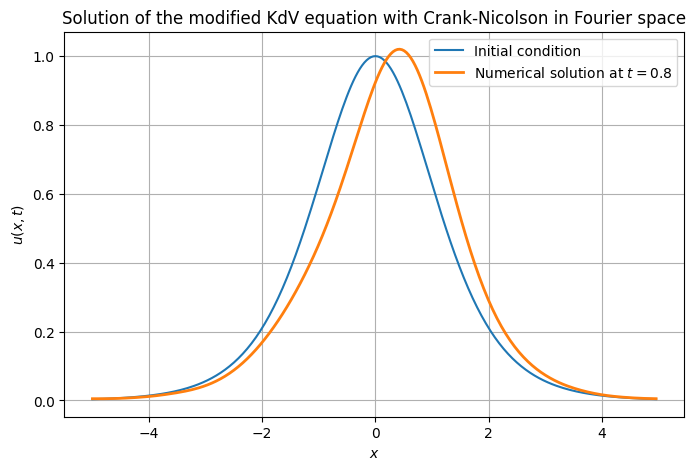

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# This code solves the modified Korteweg–de Vries equation:
# u_t + u * u_x + 0.1 * u_xxx = 0

# Domain parameters
L = 10  # Domain length in x (from -5 to 5)
Nx = 256  # Number of points in x
dx = L / Nx  # Spatial step
x = np.linspace(-5, 5, Nx, endpoint=False)  # Spatial mesh

# Time parameters
T = 0.8  # Total simulation time
dt = 1e-4  # Small time step for stability
Nt = int(T / dt)  # Number of time steps
beta = 0.1  # Dispersion coefficient of the modified equation

# Solution initialization with the given initial condition
u = 1.0 / np.cosh(x / np.sqrt(2))**2  # Initial condition u(x,0)

# Fourier transform of the initial condition
u_hat = np.fft.fft(u)
k = np.fft.fftfreq(Nx, d=dx) * 2 * np.pi  # Fourier frequencies
k3 = (1j * k) ** 3  # Third derivative in Fourier space

# Crank-Nicolson method in Fourier space
for _ in range(Nt):
    # Nonlinearity in physical space
    u = np.real(np.fft.ifft(u_hat))
    nonlinear = u * np.real(np.fft.ifft(1j * k * u_hat))

    # Step in Fourier space using Crank-Nicolson
    u_hat = (u_hat - dt * np.fft.fft(nonlinear)) / (1 + beta * dt * k3)

# Final solution in physical space
u_final = np.real(np.fft.ifft(u_hat))

# Plot the solution
plt.figure(figsize=(8, 5))
plt.plot(x, 1.0 / np.cosh(x / np.sqrt(2))**2, label="Initial condition")
plt.plot(x, u_final, label=f"Numerical solution at $t={T}$", linewidth=2)
plt.xlabel("$x$")
plt.ylabel("$u(x,t)$")
plt.title("Solution of the modified KdV equation with Crank-Nicolson in Fourier space")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd

# Crear un DataFrame con los valores de x y la solución final u_final
fourier_data = pd.DataFrame({"x": x, "u_final": u_final})

# Guardar en un archivo CSV
fourier_csv_path = "solution_fourier.csv"
fourier_data.to_csv(fourier_csv_path, index=False)

print(f"Archivo guardado en: {fourier_csv_path}")


Archivo guardado en: solution_fourier.csv


Comparación PINNs vs Fourier:
Error cuadrático medio (MSE): 0.000027
Norma L2: 0.073874


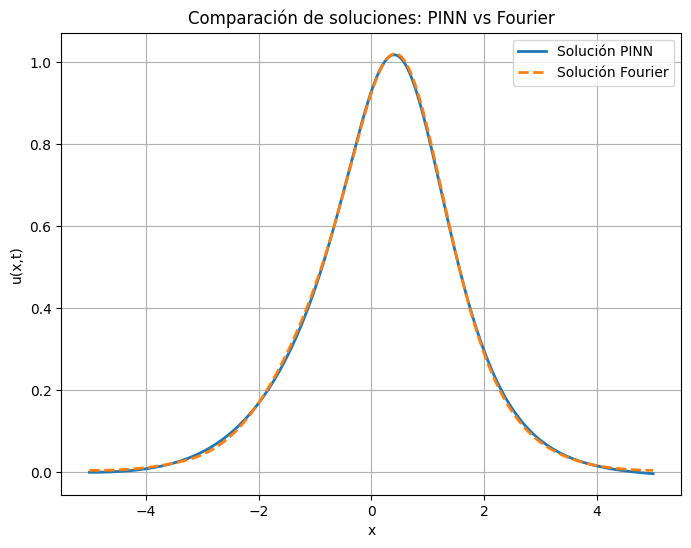

In [ ]:
from sklearn.metrics import mean_squared_error
from scipy.interpolate import interp1d
import numpy as np

# Interpolar la solución de Fourier en los mismos puntos que la PINN
fourier_interp = interp1d(x, u_final, kind="cubic", fill_value="extrapolate")

# Evaluar la solución de Fourier en los mismos puntos de la PINN
u_fourier_interp = fourier_interp(x_np)

# Calcular métricas de error entre PINN y Fourier
mse = mean_squared_error(u_fourier_interp, u_pinn_np)  # Error cuadrático medio
l2_norm = np.linalg.norm(u_fourier_interp - u_pinn_np)  # Norma L2

# Mostrar los resultados
print(f"Comparación PINNs vs Fourier:")
print(f"Error cuadrático medio (MSE): {mse:.6f}")
print(f"Norma L2: {l2_norm:.6f}")

# Graficar la comparación
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(x_np, u_pinn_np, label="Solución PINN", linestyle="-", linewidth=2)
plt.plot(x_np, u_fourier_interp, label="Solución Fourier", linestyle="--", linewidth=2)
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title("Comparación de soluciones: PINN vs Fourier")
plt.legend()
plt.grid(True)
plt.show()
